[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/eth-cscs/abcpy/master?filepath=examples%2FRejection_ABC_closer_look.ipynb)

# A closer look to Rejection ABC

In this notebook, we give some insights on how Rejection ABC (and ABC in general) works, using `ABCpy`.

## Approximate Bayesian Computation (ABC)

Approximate Bayesian Computation is a set of methods that allow to find the 'best' parameters of a scientific model with respect to observations from the real world. More specifically, ABC sits in the set of Bayesian inference methods; therefore, it provides the user not only with a point estimate of parameter values, but with a _posterior_ distribution quantifying uncertainty.


To infer the parameters of a model using ABC, three basic ingredients are required:
- A model is required that, given some input parameters, can generate synthetic observations
- Some prior knowledge about the input parameters is required (a Uniform distribution over the parameters space is always possible)
- A discrepancy function is required that quantifies how similar two sets of observations (real and synthetic) are. Here, we will use the simple Euclidean distance between observations.

**Note: we do not need the likelihood function of the bi-variate normal distribution!**

In this model, we will consider a setup in which a scientist measures height and weigth of a set of people and wants to use a statistical model to describe them; moreover, she also wants to find the posterior distributon over parameters.

In [1]:
from math import cos, sin, pi

import matplotlib.mlab as mlab
import numpy as np
import scipy
from matplotlib import gridspec, pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal
from abcpy.probabilisticmodels import ProbabilisticModel, Continuous, InputConnector
from abcpy.continuousmodels import Uniform
from abcpy.statistics import Identity
from abcpy.distances import Euclidean
from abcpy.inferences import RejectionABC
from abcpy.backends import BackendDummy as Backend

%matplotlib inline

Let us define the model we will consider; this is specifically a bivariate normal model, in which the covariance matrix is defined in the following way (method `get_cov`): 

- the standard deviations s1 and s2 are used to define a diagonal covariance matrix
- then, a rotation matrix corresponding to angle alpha is used to rotate that to a correlated covariance matrix. 

Essentially, then, s1 and s2 are the standard deviation of the final bivariate normal along the directions in which the two components are uncorrelated. This is related to eigendecomposition, but this is not the main point here. 

We use `ABCpy` API to define the model:

In [2]:
class BivariateNormal(ProbabilisticModel, Continuous):

    def __init__(self, parameters, name='BivariateNormal'):
        # We expect input of type parameters = [m1, m2, s1, s2, alpha]
        if not isinstance(parameters, list):
            raise TypeError('Input of Normal model is of type list')

        if len(parameters) != 5:
            raise RuntimeError('Input list must be of length 5, containing [m1, m2, s1, s2, alpha].')

        input_connector = InputConnector.from_list(parameters)
        super().__init__(input_connector, name)

    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != 5:
            raise ValueError('Number of parameters of BivariateNormal model must be 5.')

        # Check whether input is from correct domain
        m1 = input_values[0]
        m2 = input_values[1]
        s1 = input_values[2]
        s2 = input_values[3]
        alpha = input_values[4]
        if s1 < 0 or s2 < 0:
            return False

        return True

    def _check_output(self, values):
        if not isinstance(values, np.array):
            raise ValueError('This returns a bivariate array')
        
        if values.shape[0] != 2: 
            raise RuntimeError('The size of the output has to be 2.')
        
        return True

    def get_output_dimension(self):
        return 2

    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
        m1 = input_values[0]
        m2 = input_values[1]
        s1 = input_values[2]
        s2 = input_values[3]
        alpha = input_values[4]
        
        mean = np.array([m1, m2])
        cov = self.get_cov(s1, s2, alpha)
        
        obs_pd = multivariate_normal(mean=mean, cov=cov)
        vector_of_k_samples = obs_pd.rvs(k)

        # Format the output to obey API
        result = [np.array([x]) for x in vector_of_k_samples]
        return result

    def get_cov(self, s1, s2, alpha):
        """Function to generate a covariance bivariate covariance matrix; it starts from considering a
        diagonal covariance matrix with standard deviations s1, s2 and then applies the rotation matrix with 
        angle alpha. """
        r = np.array([[cos(alpha), -sin(alpha)], [sin(alpha), cos(alpha)]]) # Rotation matrix
        e = np.array([[s1, 0], [0, s2]]) # Eigenvalue matrix
        rde = np.dot(r, e)
        rt = np.transpose(r)
        cov = np.dot(rde, rt)
        return cov

Next, we define some help functions for plots:

In [3]:
def plot_dspace(ax, sl, marker, color):
    """Plot the data in 'sl' on 'ax';"""
    ax.set_xlim(100,220)
    ax.set_ylim(30,150)
    ax.set_xlabel('Height in cm')
    ax.set_ylabel('Weigth in kg')
    for samples in sl:
        ax.plot(samples[:,0], samples[:,1], marker, c=color)

In [4]:
def plot_pspace(ax_means, ax_vars, ax_angle, m1, m2, s1, s2, alpha, color):
    """Plot parameter space. m1 and m2 are the means of the height and weight respectively, while s1, s2 are 
    two standard deviations for the eigenvalue normal components. Finally, alpha is the angle that determines the 
    amount of rotation applied to the two independent components to get the covariance matrix."""
    ax_means.set_xlabel('Mean of height')
    ax_means.set_ylabel('Mean of weight')
    ax_means.set_xlim(120,200)
    ax_means.set_ylim(50,150)
    ax_means.plot(m1, m2, 'o', c=color)

    ax_vars.set_xlabel('Standard deviation 1')
    ax_vars.set_ylabel('Standard deviation 2')
    ax_vars.set_xlim(0,100)
    ax_vars.set_ylim(0,100)
    ax_vars.plot(s1, s2, 'o', c=color)
    
    ax_angle.set_xlabel('Rotation angle')
    ax_angle.set_xlim(0, pi/2)
    ax_angle.set_yticks([])
    ax_angle.plot(np.linspace(0, pi, 10), [0]*10, c='black', linewidth=0.2)
    ax_angle.plot(alpha, 0, 'o', c=color)

In [5]:
def plot_all(axs, m1, m2, s1, s2, alpha, color, marker, model, k):
    """Function plotting pameters, generating data from them and plotting data too. It uses the model 
    to generate k samples from the provided set of parameters. 
    
    m1 and m2 are the means of the height and weight respectively, while s1, s2 are 
    two standard deviations for the eigenvalue normal components. Finally, alpha is the angle that determines the 
    amount of rotation applied to the two independent components to get the covariance matrix.
    """
    ax_pspace_means, ax_pspace_vars, ax_pspace_angle, ax_dspace = axs
    plot_pspace(ax_pspace_means, ax_pspace_vars, ax_pspace_angle, m1, m2, s1, s2, alpha, color)
    samples = model.forward_simulate([m1, m2, s1, s2, alpha], k)
    plot_dspace(ax_dspace, samples, marker, color)

Define now the probabilistic model; we put uniform priors on the parameters:

In [6]:
m1 = Uniform([[120], [200]], name="Mean_height")
m2 = Uniform([[50], [150]], name="Mean_weigth")
s1 = Uniform([[0], [100]], name="sd_1")
s2 = Uniform([[0], [100]], name="sd_2")
alpha = Uniform([[0], [pi/2]], name="alpha")

bivariate_normal = BivariateNormal([m1, m2, s1, s2, alpha])

Assume now that the scientist obtained an observation, from field data, that was generated by the model with a specific set of parameters `obs_par`; this is of course fictitious, but we take this assumption in order to check whether we are able to recover decently the actual model parameters we used.

In [7]:
obs_par = np.array([175, 75, 90, 35, pi/4.])
obs = bivariate_normal.forward_simulate(obs_par, 100)

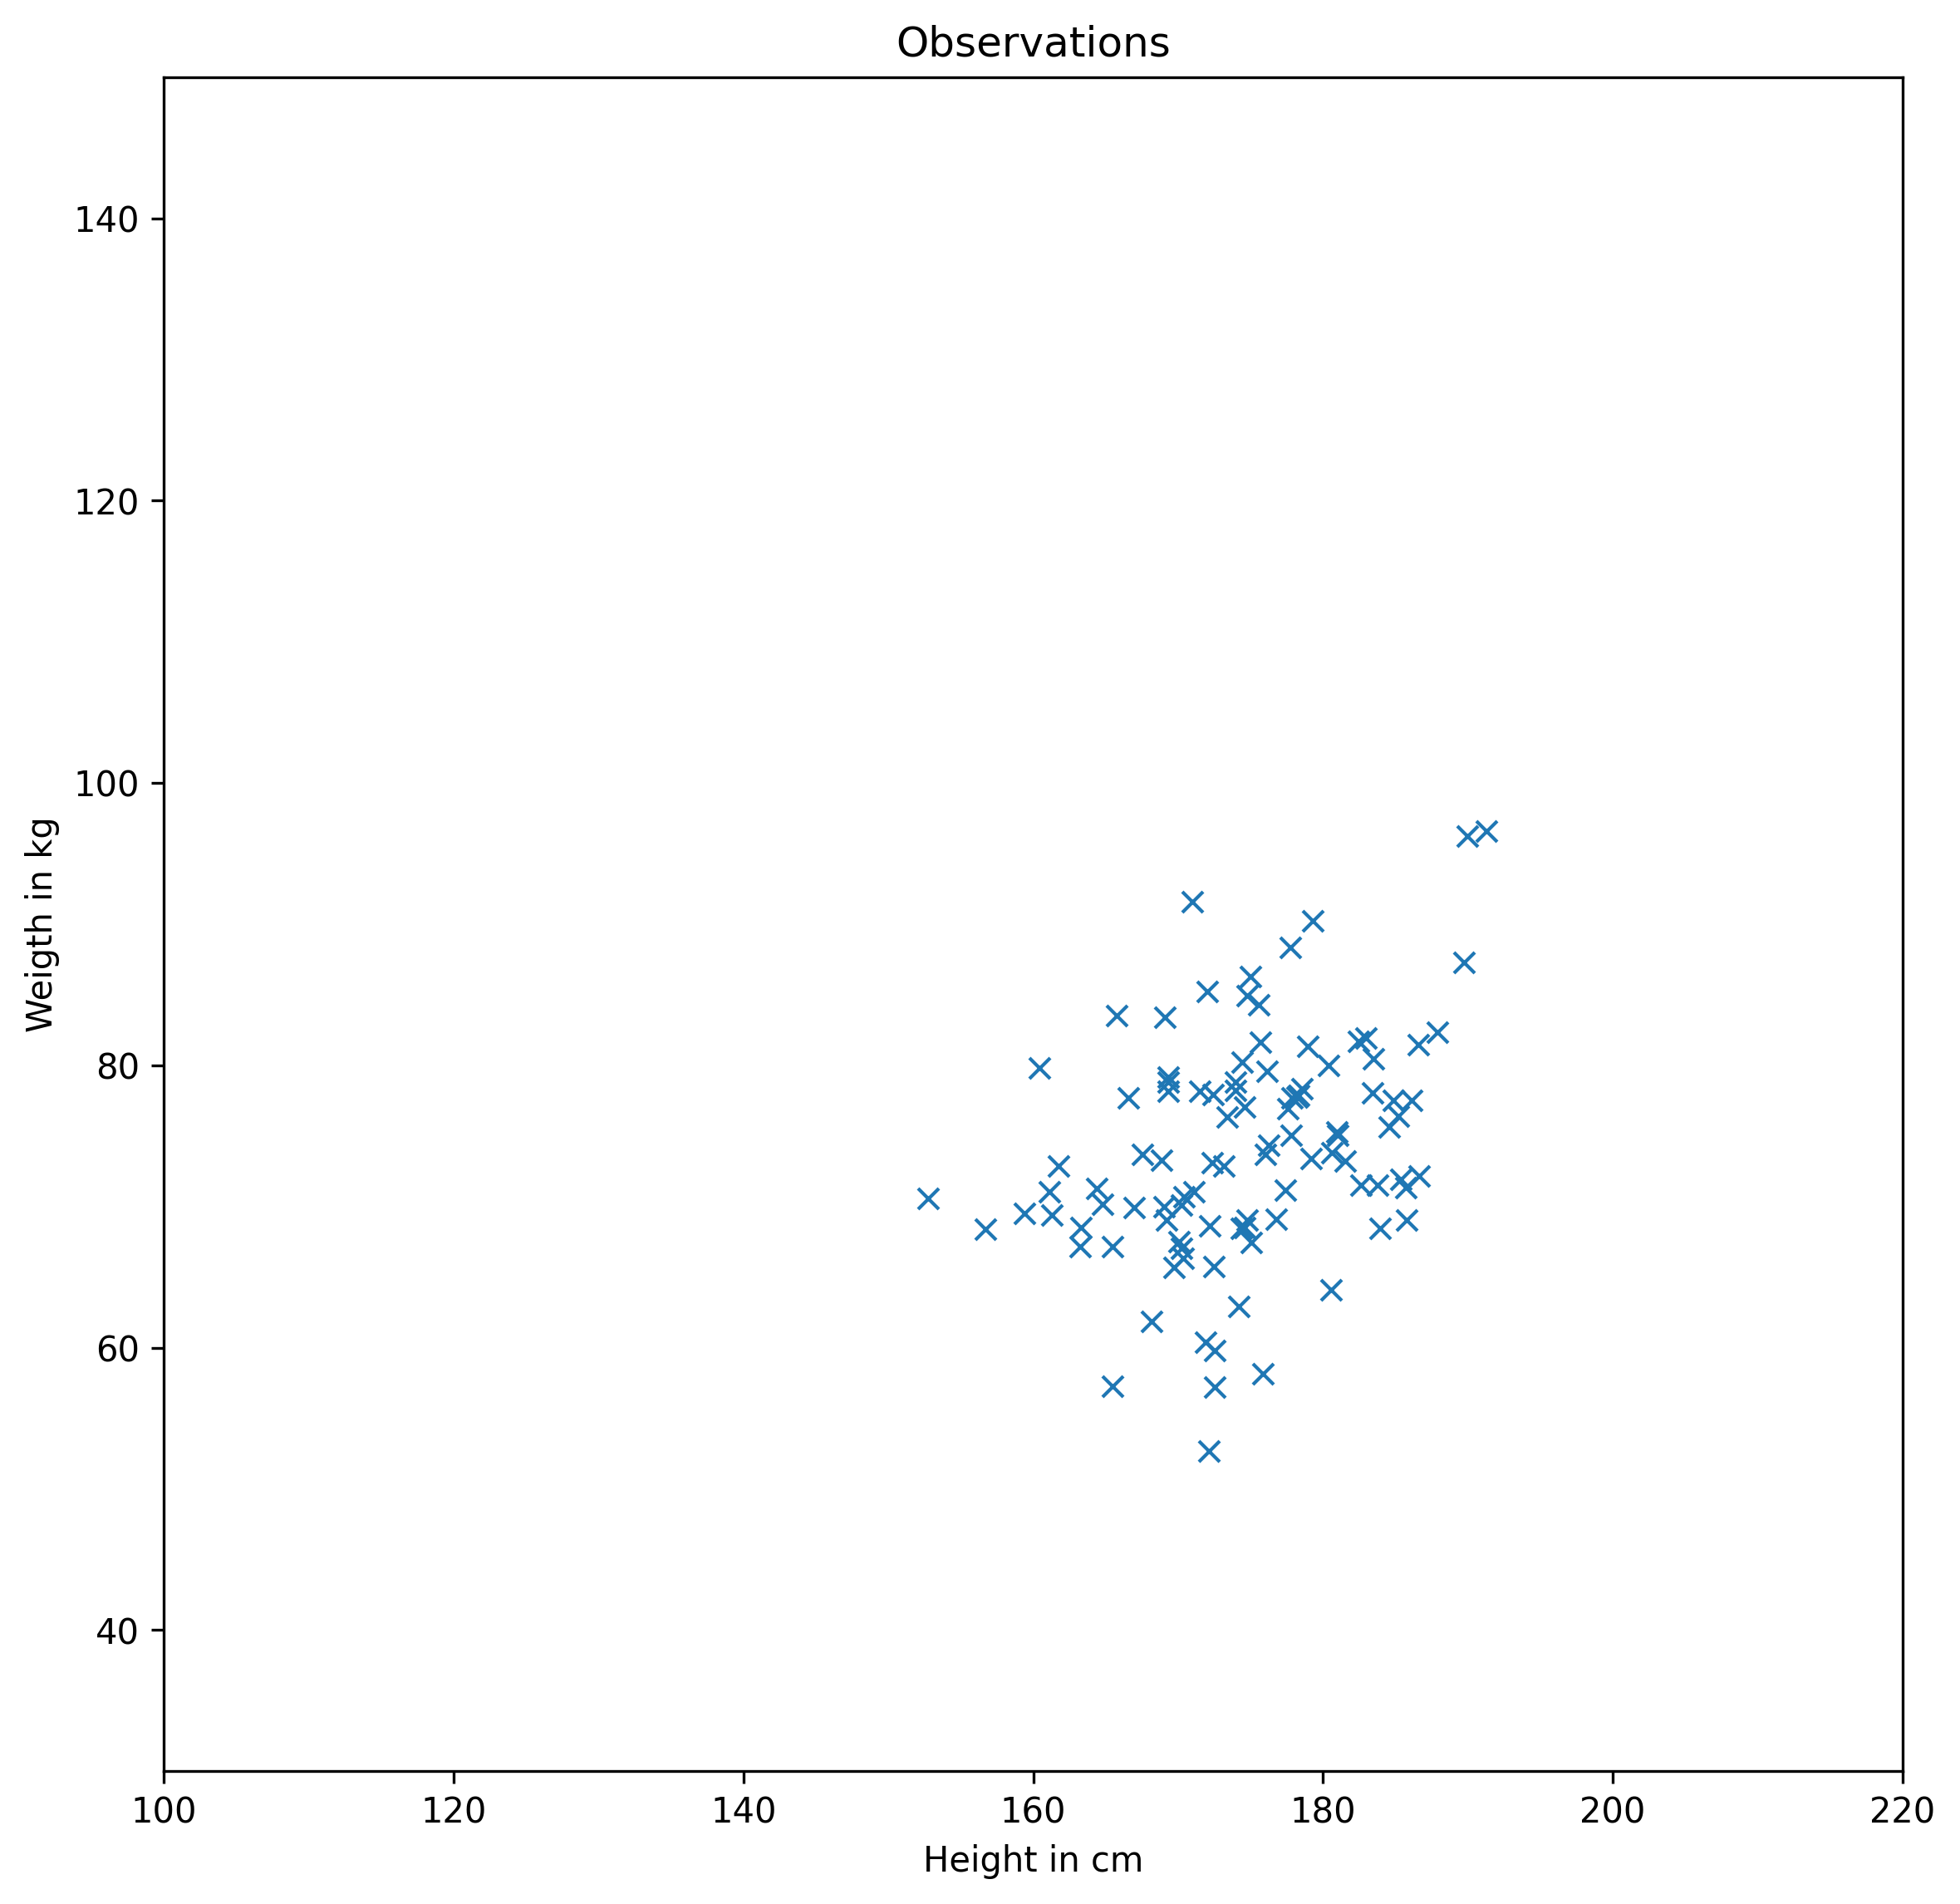

In [8]:
fig_obs = plt.figure(dpi=300)
fig_obs.set_size_inches(9,9)
ax_obs = fig_obs.add_subplot(111)
ax_obs.set_title('Observations')
plot_dspace(ax_obs, obs, 'x', 'C0')

## Rejection ABC
This is the most fundamental algorithm for ABC; it works in four steps:

Repeat:
1. draw a parameter sample theta from the prior
2. generate synthetic observations from the model using theta
3. compute the distance between observed and synthetic data
4. if the distance is smaller than a threshold, add theta to accepted parameters

And the loop continues until enough parameter values are accepted. The output is a set of accepted parameters, that resembles the parameters 'true' (posterior) distribution.


![Rejection ABC image](https://github.com/eth-cscs/abcpy/raw/master/doc/source/ABC_rejection.png)

### RejectionABC in Figures
We will now display the observations generated from the model for a set of parameter values; specifically, we consider 4 different sets of parameter values (corresponding to the four different colors) which are displayed in the left hand side set of plot; the corresponding observations are of the same color in the right plot; in the latter, we also show the observation (blue).


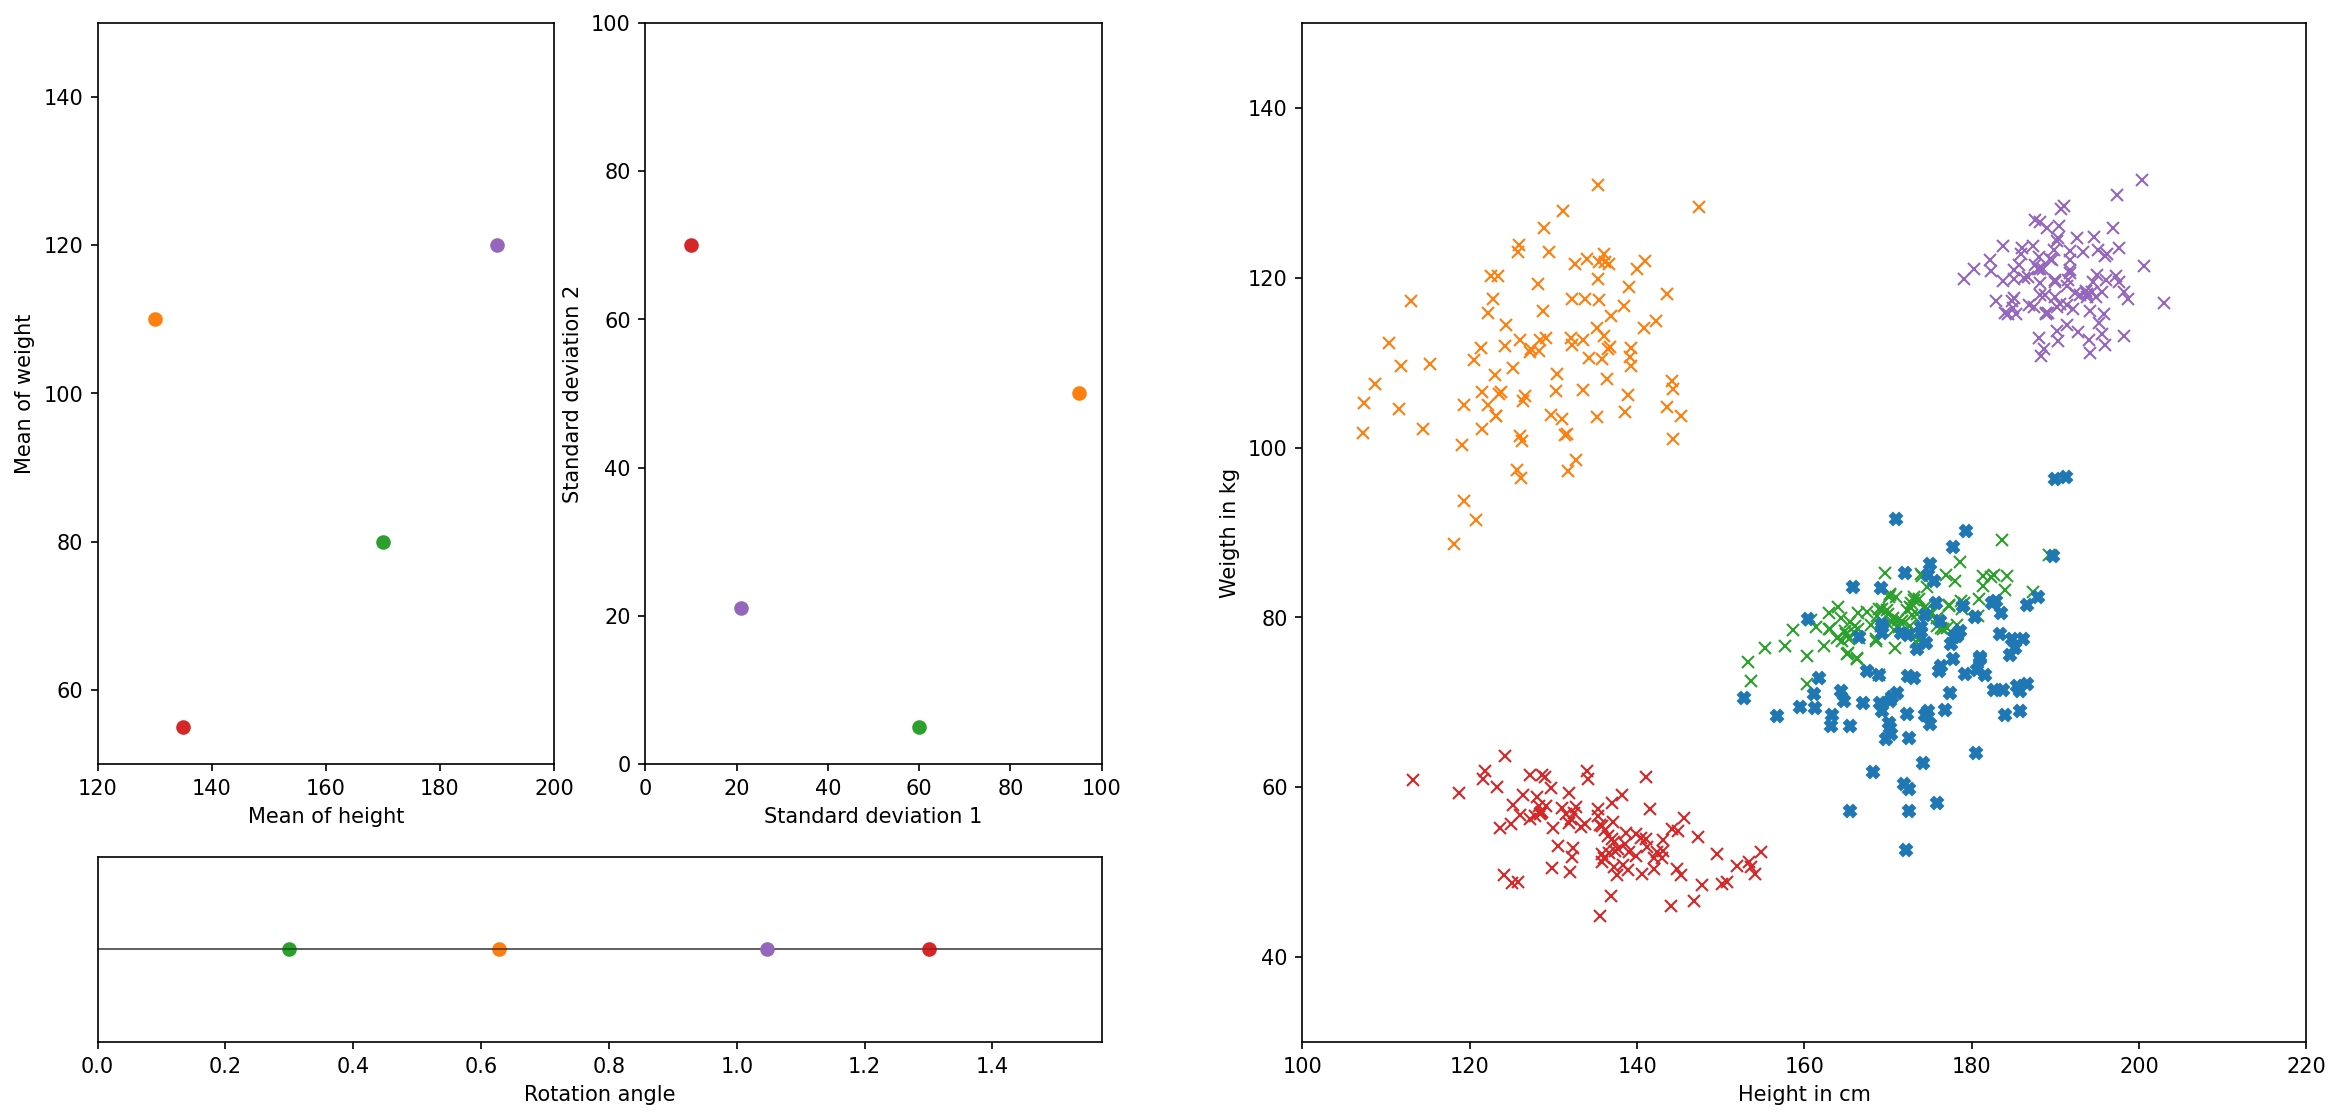

In [9]:
np.random.seed(0)
fig_sim = plt.figure(dpi=150)
fig_sim.set_size_inches(19, 9)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])
gs_pspace = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0], width_ratios=[1, 1], height_ratios=[4,1])
ax_pspace_means = plt.subplot(gs_pspace[0,0])
ax_pspace_vars = plt.subplot(gs_pspace[0,1])
ax_pspace_angle = plt.subplot(gs_pspace[1,:])
ax_dspace = plt.subplot(gs[0,1])
axs = (ax_pspace_means, ax_pspace_vars, ax_pspace_angle, ax_dspace)

#plot_dspace(ax_dspace, [obs], 'x', 'C0')
plot_all(axs, 130,110,95,50,pi/5, 'C1', 'x', bivariate_normal, 100)
plot_all(axs, 170,80,60,5,0.3, 'C2', 'x', bivariate_normal, 100)
plot_all(axs, 135,55,10,70,1.3, 'C3', 'x', bivariate_normal, 100)
plot_all(axs, 190,120,21,21,pi/3., 'C4', 'x', bivariate_normal, 100)
plot_dspace(ax_dspace, obs, 'X', 'C0')

The idea of ABC is the following: similar data sets come from similar sets of parameters. For this reason, to obtain the best parameter values which fit the observation, we will compare the observation with the synthetic data for different choices of parameters, for instance, above you can see that the green dataset is a better match for the observation than the others.

Let us now generate some samples from the prior and see how well they fit the observation:

In [10]:
n_prior_samples = 100
params_prior = np.zeros((n_prior_samples,5))

for i in range(n_prior_samples):
    m1_val = m1.forward_simulate([[120], [200]], k=1)
    m2_val = m2.forward_simulate([[50], [150]], k=1)
    s1_val = s1.forward_simulate([[0], [100]], k=1)
    s2_val = s2.forward_simulate([[0], [100]], k=1)
    alpha_val = alpha.forward_simulate([[0], [pi / 2]], k=1)
    
    params_prior[i] = np.array([m1_val, m2_val, s1_val, s2_val, alpha_val]).squeeze()

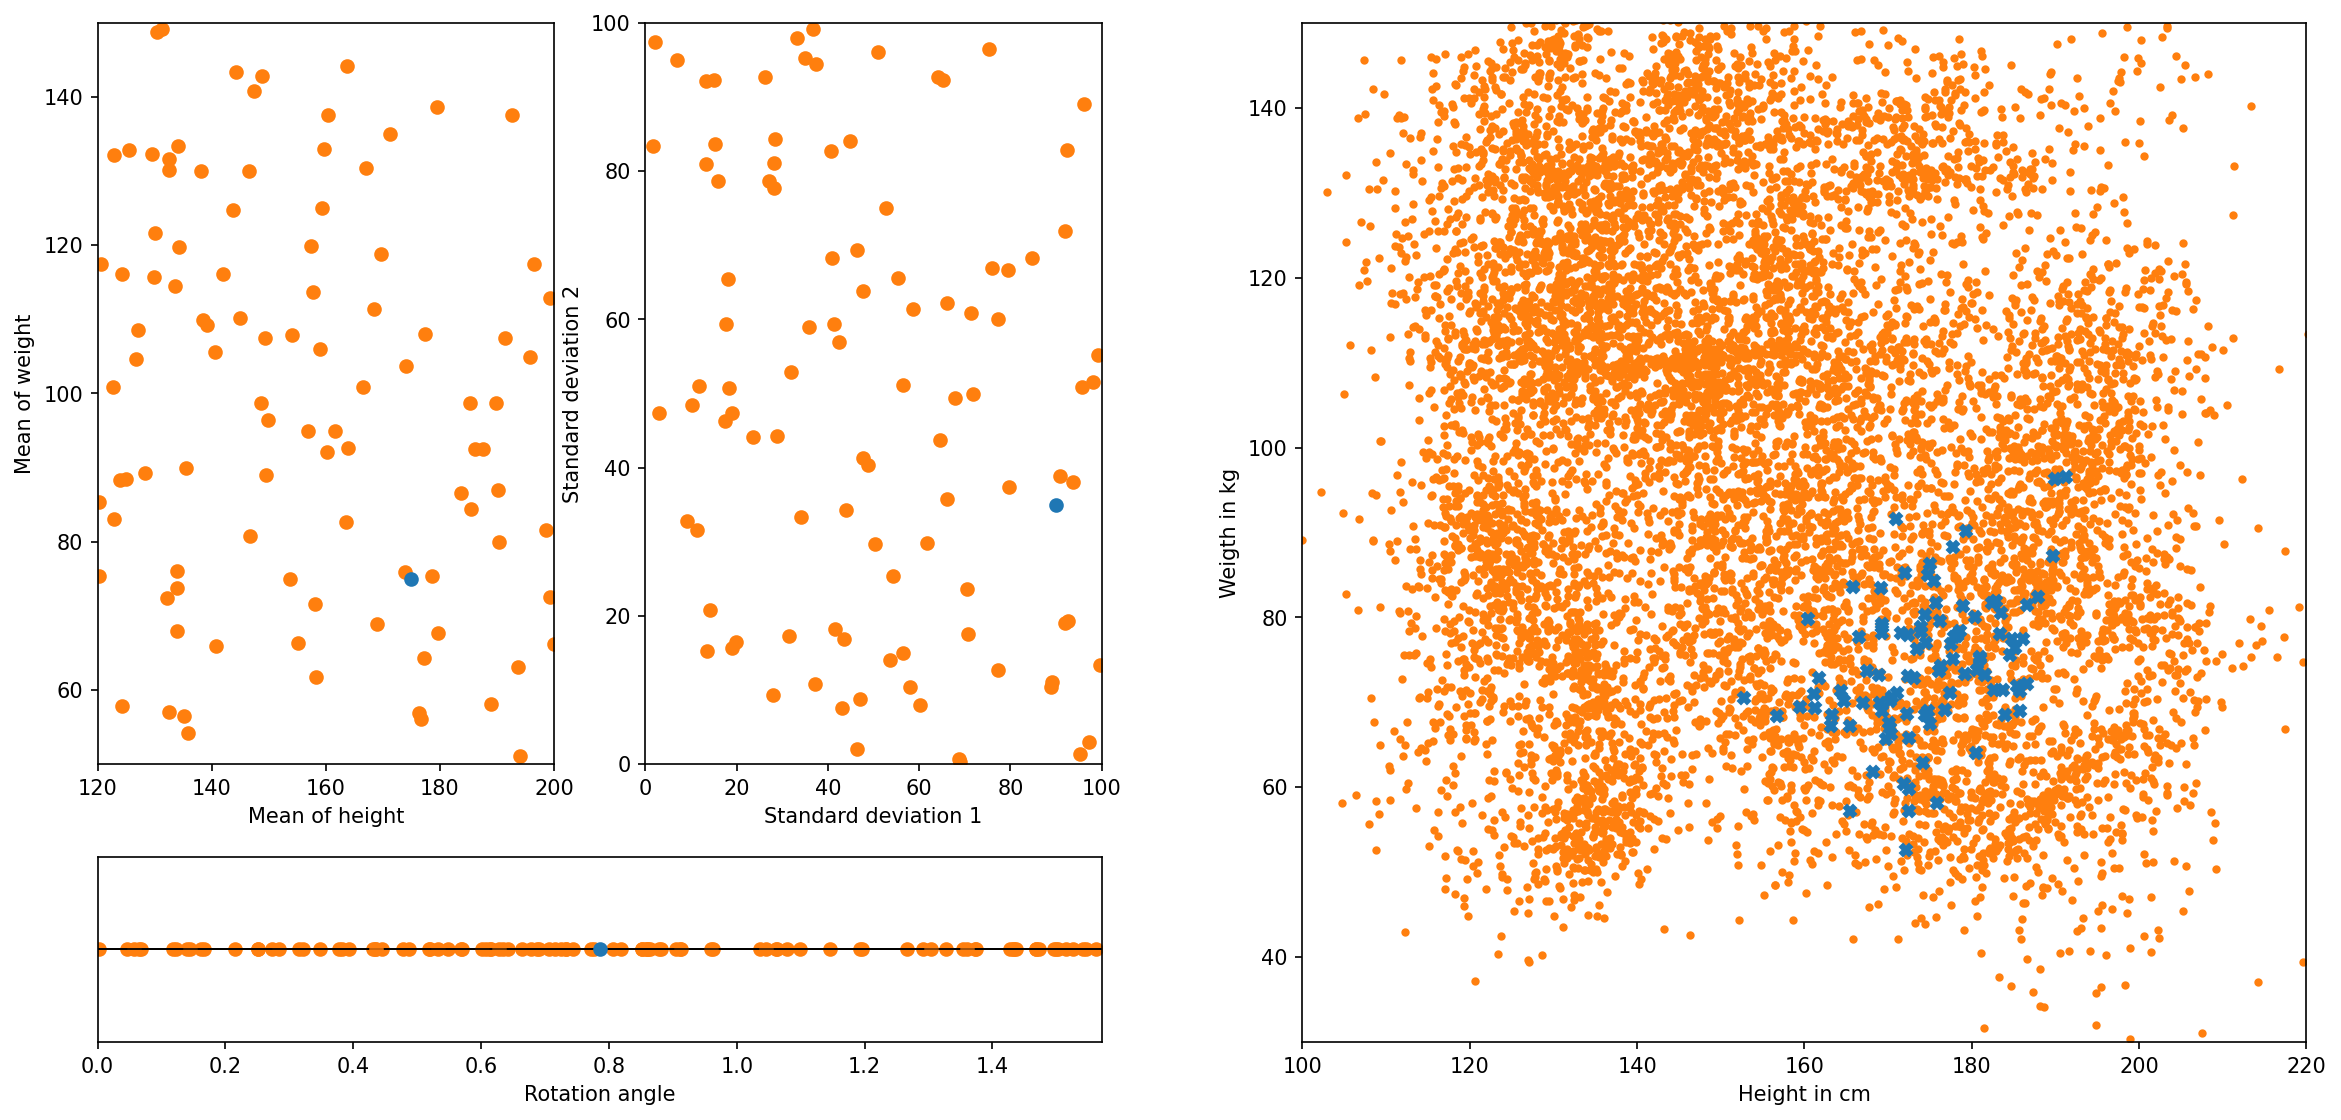

In [11]:
np.random.seed(0)
fig_abc1 = plt.figure(dpi=150)
fig_abc1.set_size_inches(19, 9)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])
gs_pspace = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0], width_ratios=[1, 1], height_ratios=[4,1])
ax_pspace_means = plt.subplot(gs_pspace[0,0])
ax_pspace_vars = plt.subplot(gs_pspace[0,1])
ax_pspace_angle = plt.subplot(gs_pspace[1,:])
ax_dspace = plt.subplot(gs[0,1])
axs = (ax_pspace_means, ax_pspace_vars, ax_pspace_angle, ax_dspace)

for i in range(0, n_prior_samples):
    plot_all(axs, params_prior[i,0], params_prior[i,1], params_prior[i,2], params_prior[i,3], params_prior[i,4], 
             'C1', '.', bivariate_normal, k=100)

plot_pspace(ax_pspace_means, ax_pspace_vars, ax_pspace_angle, *obs_par, color="C0")
plot_dspace(ax_dspace, obs, 'X', 'C0')

Above, the blue dot represent the parameter values which originated the observation, while the orange parameter values are the ones sampled from the prior; the corresponding synthetic datasets are shown as orange clouds of dots, while the observation is shown as blue crosses.

### Inference
Now, let's perform inference with Rejection ABC to get some approximate posterior samples: 

In [12]:
statistics_calculator = Identity()
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([bivariate_normal], [distance_calculator], backend, seed=1)

Sampling may take a while. It will take longer the more you decrease the threshold epsilon or increase the number of samples. 

In [13]:
n_samples = 100  # number of posterior samples we aim for
n_samples_per_param = 100  # number of simulations for each set of parameter values
journal = sampler.sample([obs], n_samples, n_samples_per_param, epsilon=15)

In [14]:
print(journal.number_of_simulations)

[3732]


Now, we will produce a plot similar to the above one for the prior but starting from the posterior samples. 

In [15]:
posterior_samples = np.array(journal.get_accepted_parameters()).squeeze()

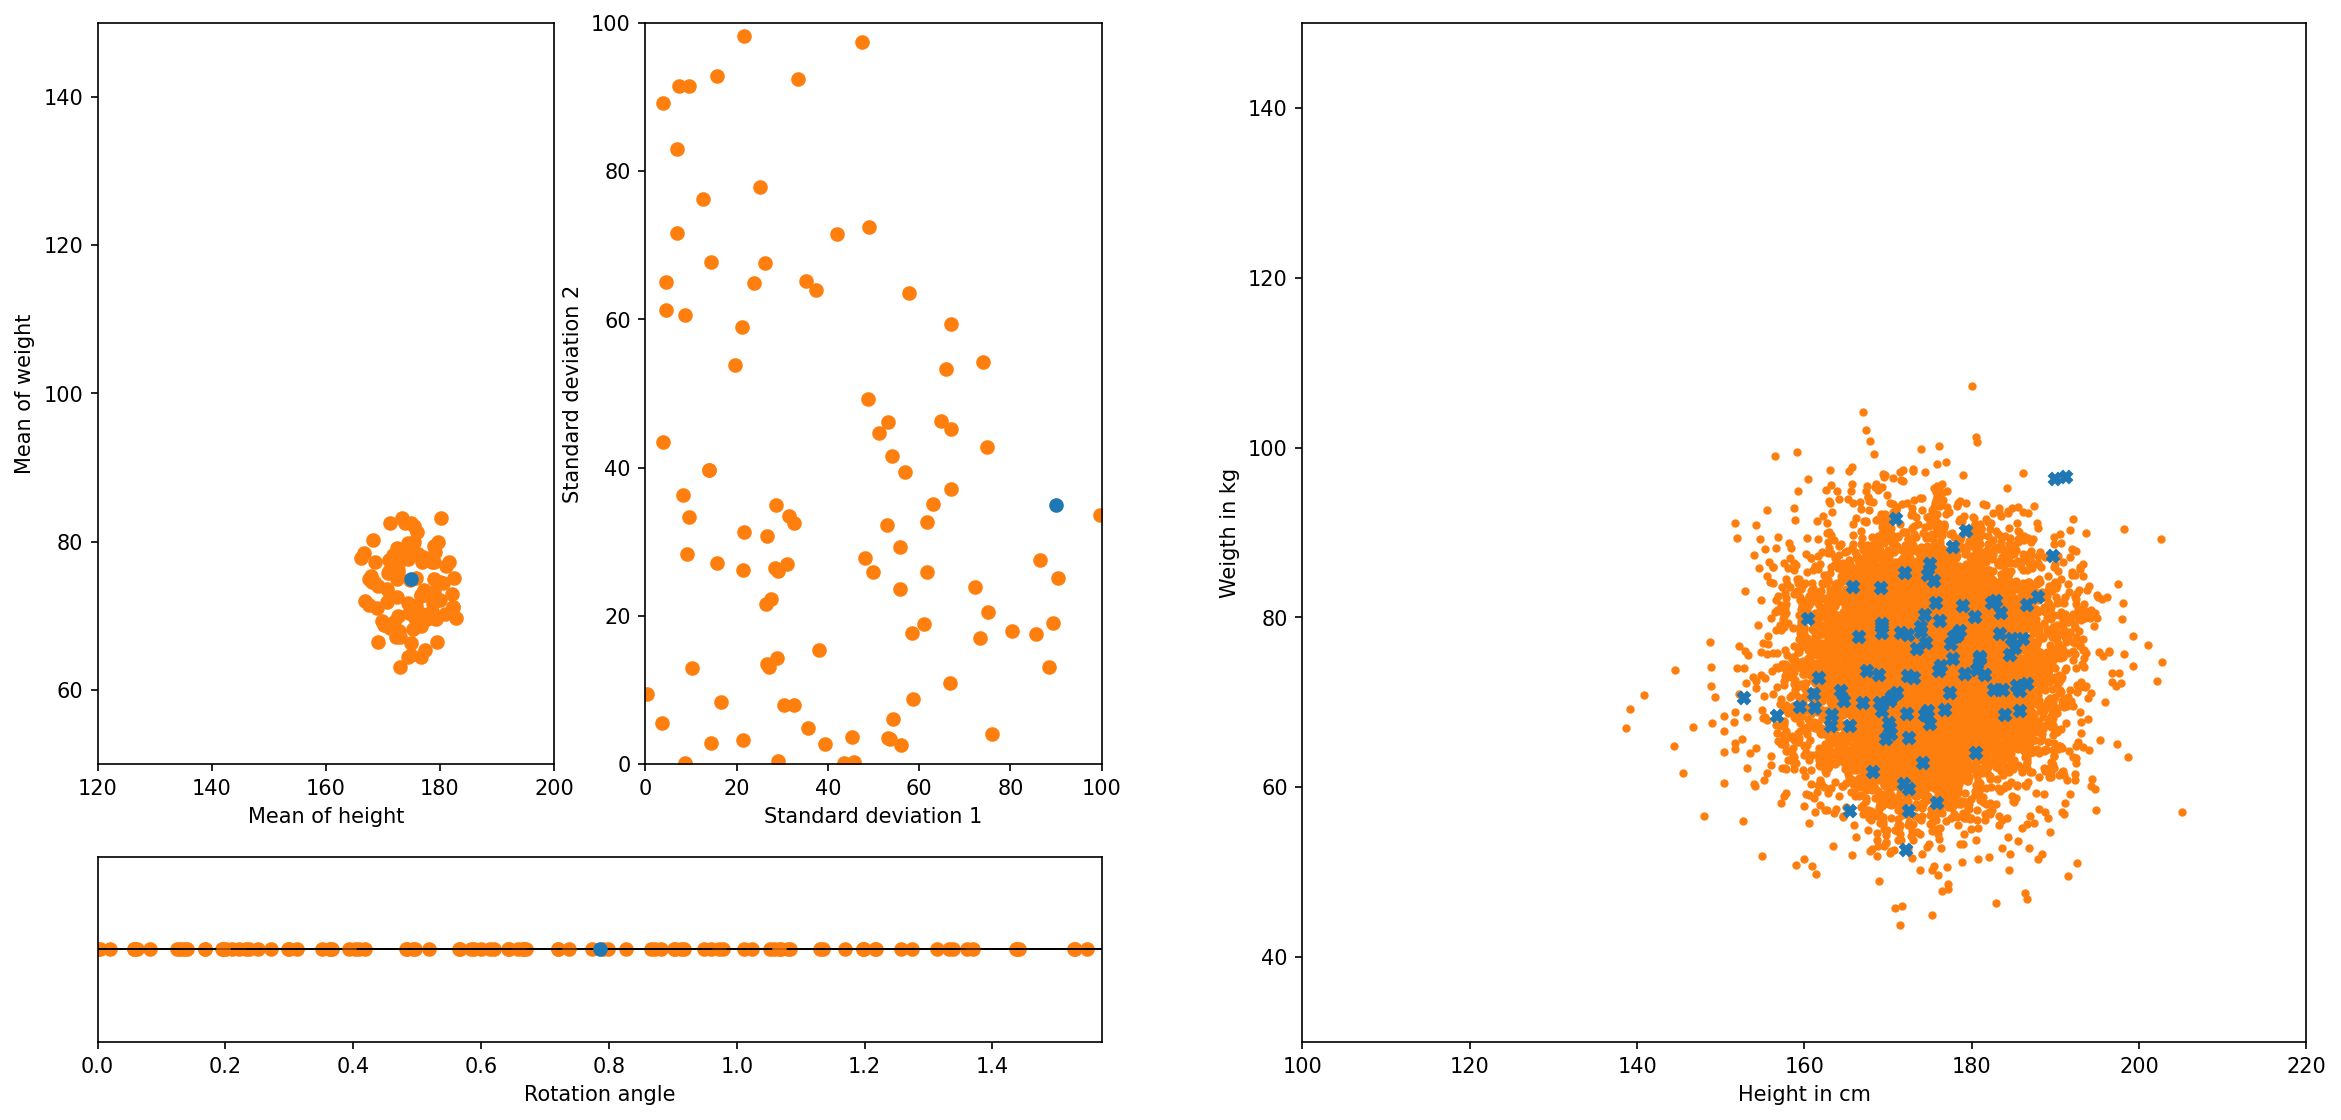

In [16]:
np.random.seed(0)
fig_abc1 = plt.figure(dpi=150)
fig_abc1.set_size_inches(19, 9)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])
gs_pspace = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0], width_ratios=[1, 1], height_ratios=[4,1])
ax_pspace_means = plt.subplot(gs_pspace[0,0])
ax_pspace_vars = plt.subplot(gs_pspace[0,1])
ax_pspace_angle = plt.subplot(gs_pspace[1,:])
ax_dspace = plt.subplot(gs[0,1])
axs = (ax_pspace_means, ax_pspace_vars, ax_pspace_angle, ax_dspace)

for i in range(0, n_samples):
    plot_all(axs, posterior_samples[i,0], posterior_samples[i,1], posterior_samples[i,2], posterior_samples[i,3], 
             posterior_samples[i,4], 'C1', '.', bivariate_normal, k=100)
    
plot_pspace(ax_pspace_means, ax_pspace_vars, ax_pspace_angle, *obs_par, color="C0")
plot_dspace(ax_dspace, obs, 'X', 'C0')

Now, you can see that the sythetic datasets are much closer to the observation. Also, the parameter values which generated those are not anymore evenly spread on the parameter space.

The mean parameters are very much concentrated close to the exact parameter value; with regards to the other ones, they are a bit more spread out.